In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from imutils.contours import sort_contours
import imutils
import pathlib

2023-05-10 15:21:58.277837: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bob9952/.local/lib/python3.9/site-packages/cv2/../../lib64:
2023-05-10 15:21:58.277915: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-10 15:21:58.846170: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-10 15:22:13.116537: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bob9952/.local/lib/python3.9/site-packages/cv2/../../lib64:
2023-05-10 15:22

In [2]:
# data_dir = pathlib.Path('../projekat/handwritten/dataset')

In [3]:
# import splitfolders
# splitfolders.ratio(data_dir, output="output", seed=1337, ratio=(.8, 0.1,0.1))

In [4]:
train_path = "./output/train"
test_path  = "./output/test"
val_path = "./output/val"

In [5]:
import os
import pandas as pd
from glob import glob
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.image import imread 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
%matplotlib inline

2023-05-10 02:00:47.154181: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/db2inst1/sqllib/lib64:/home/db2inst1/sqllib/lib64/gskit:/home/db2inst1/sqllib/lib32
2023-05-10 02:00:47.154409: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-10 02:00:47.716269: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-10 02:00:59.170268: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/db2inst1/sqllib/lib64:/home/db2inst1/sqllib/lib64/gs

In [88]:
image_shape = (100,100,3)
epochs = 8
batch_size = 32

In [116]:
def bitwise_invert(image):
    temp = tf.image.rgb_to_grayscale(255 -
    image)
    # temp = np.abs(255 - temp)
    temp = tf.image.grayscale_to_rgb(temp)
    #temp = np.abs(255 - image)
    return temp


traindata_gen=ImageDataGenerator(
                             rotation_range=10,
                             rescale=1.0/255,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1,
                              zoom_range=0.1,
                             fill_mode='nearest',
                             preprocessing_function=bitwise_invert
                              )

testdata_gen=ImageDataGenerator(
                                rescale=1.0/255,
                                preprocessing_function=bitwise_invert
                             )

valdatagen = ImageDataGenerator(
                            rescale=1.0/255,
                            preprocessing_function=bitwise_invert
                    )

In [117]:
train_set=traindata_gen.flow_from_directory(train_path,
                                              target_size =image_shape[:2],
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 color_mode = 'rgb',
                                           shuffle=True,
                                           seed=3301)

test_set=testdata_gen.flow_from_directory(test_path,
                                            target_size = image_shape[:2],
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                color_mode = 'rgb',
                                            shuffle=False)
val_set = valdatagen.flow_from_directory(val_path,
                                            target_size = image_shape[:2],
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 color_mode = 'rgb',
                                            shuffle=True )

Found 7199 images belonging to 16 classes.
Found 915 images belonging to 16 classes.
Found 894 images belonging to 16 classes.


In [118]:
class_labels = list(train_set.class_indices.keys())   
num_classes = len(class_labels)
print(class_labels)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'dec', 'div', 'eq', 'mul', 'sub']


(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)


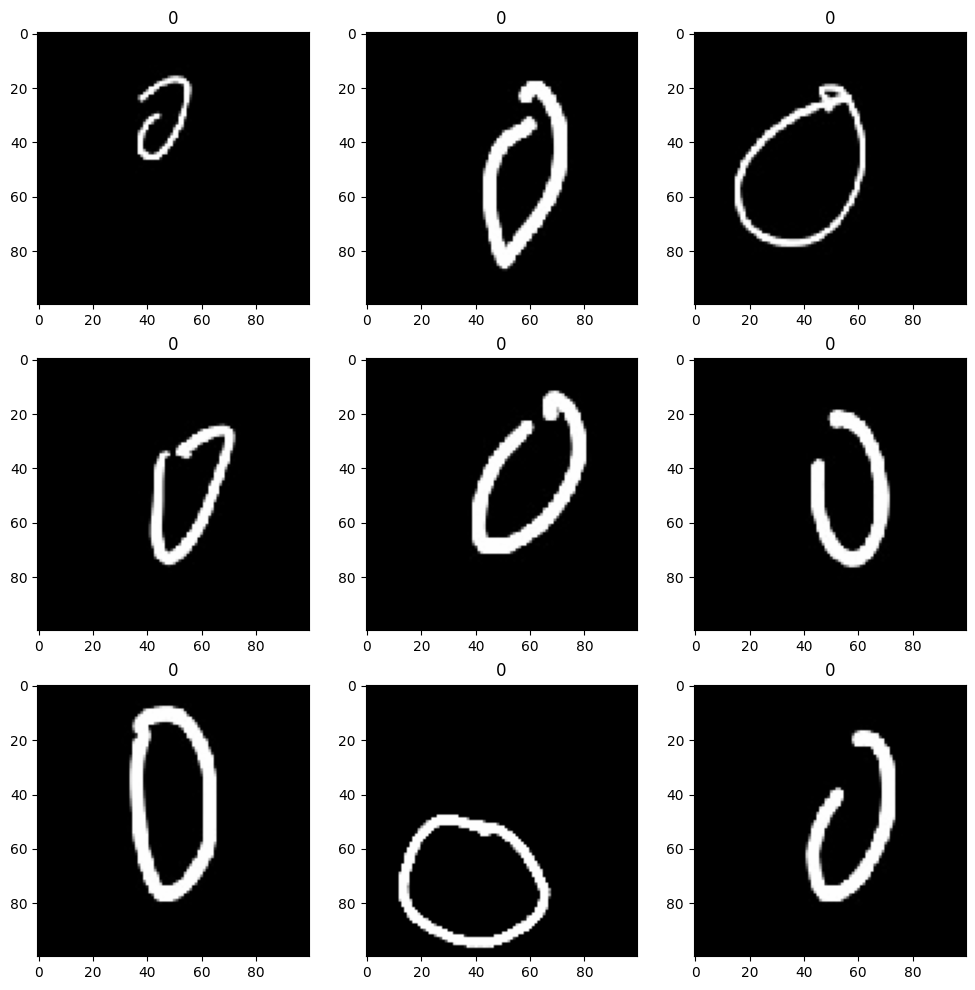

In [119]:
plt.figure(figsize=(12, 12))
for images, labels in test_set:
    for i in range(9):
        plt.subplot(330 + 1 + i)
        image = images[i]
        print(image.shape)
        label = class_labels[np.argmax(labels[i])]
        #plt.imshow(image, cmap='gray', vmin=0, vmax=1)
        plt.imshow(image)
        plt.title(label)
    break

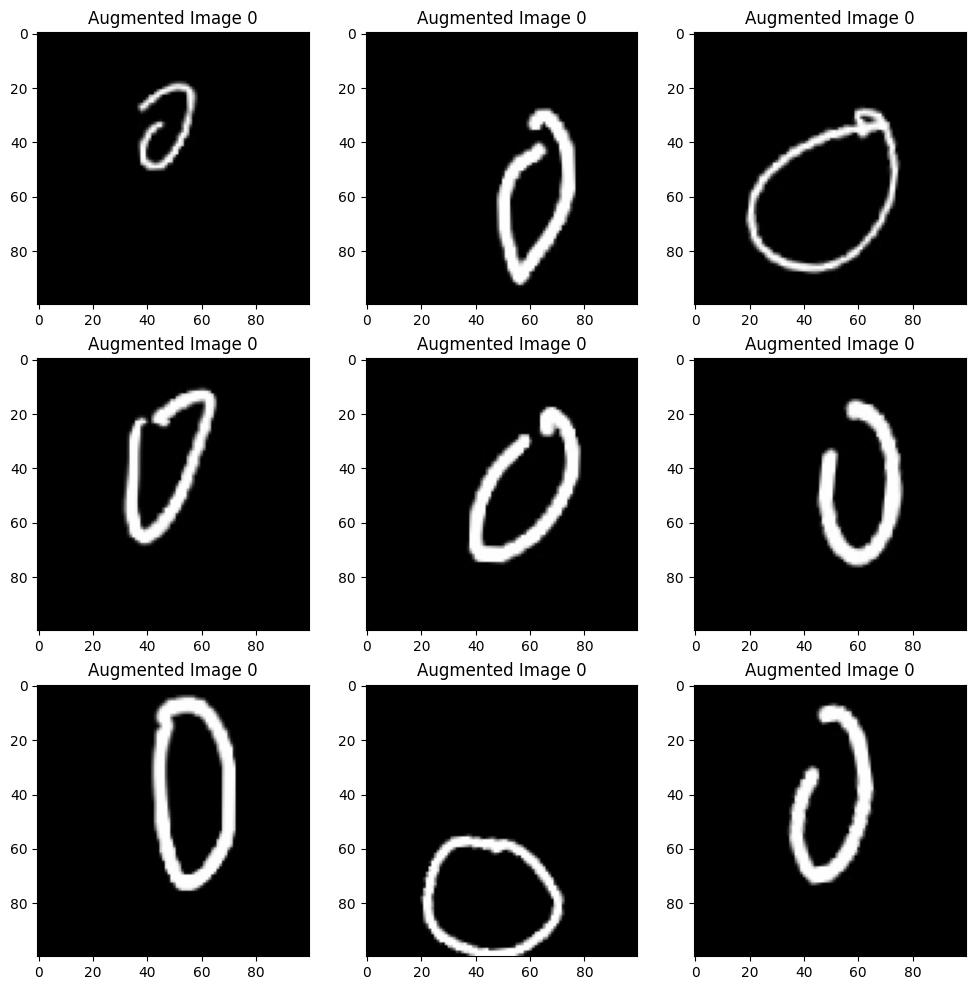

In [120]:
plt.figure(figsize=(12, 12))
for img_batch,label_batch in train_set:
    for i in range(9):
        plt.subplot(330 + 1 + i)
        image = images[i]
        label = class_labels[np.argmax(labels[i])]
        tx_img = traindata_gen.random_transform(image)
        plt.imshow(tx_img, cmap='gray', vmin=0, vmax=1)
        plt.title('Augmented Image ' + label)
        
    break

In [121]:
base_model=tf.keras.applications.MobileNetV2( include_top=False, input_shape=image_shape, pooling='max', weights='imagenet') 
base_model.trainable = False
x=base_model.output

x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.016) ,activation='relu', kernel_initializer= tf.keras.initializers.GlorotUniform(seed=123))(x)

x=Dropout(rate=.3, seed=123)(x)         

output=Dense(num_classes, activation='softmax',kernel_initializer=tf.keras.initializers.GlorotUniform(seed=123))(x)

model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy'])  

early_stop=tf.keras.callbacks.EarlyStopping( monitor="val_loss",  patience=2, verbose=1,restore_best_weights=True)

In [122]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 50, 50, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 50, 50, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 50, 50, 32)   0           ['bn_Conv1[0][0]']           

In [123]:
result = model.fit(
  train_set,
  epochs=epochs,
  validation_data=val_set,
  callbacks=[early_stop]
    
)

Epoch 1/8


2023-05-10 03:09:32.101616: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 30720000 exceeds 10% of free system memory.
2023-05-10 03:09:32.153798: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 31961088 exceeds 10% of free system memory.


  1/225 [..............................] - ETA: 46:50 - loss: 21.6713 - accuracy: 0.1250

2023-05-10 03:09:33.338482: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 30720000 exceeds 10% of free system memory.
2023-05-10 03:09:33.442977: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 31961088 exceeds 10% of free system memory.


  2/225 [..............................] - ETA: 3:19 - loss: 21.1668 - accuracy: 0.2031 

2023-05-10 03:09:34.436363: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 30720000 exceeds 10% of free system memory.


225/225 [==============================] - 240s 1s/step - loss: 10.7676 - accuracy: 0.8539 - val_loss: 5.5975 - val_accuracy: 0.9374
Epoch 2/8
225/225 [==============================] - 216s 957ms/step - loss: 3.4606 - accuracy: 0.9272 - val_loss: 1.9741 - val_accuracy: 0.9385
Epoch 3/8
225/225 [==============================] - 229s 1s/step - loss: 1.3350 - accuracy: 0.9332 - val_loss: 0.8942 - val_accuracy: 0.9351
Epoch 4/8
225/225 [==============================] - 214s 951ms/step - loss: 0.7251 - accuracy: 0.9365 - val_loss: 0.5857 - val_accuracy: 0.9407
Epoch 5/8
225/225 [==============================] - 210s 930ms/step - loss: 0.5404 - accuracy: 0.9351 - val_loss: 0.4932 - val_accuracy: 0.9396
Epoch 6/8
225/225 [==============================] - 228s 1s/step - loss: 0.4624 - accuracy: 0.9403 - val_loss: 0.4321 - val_accuracy: 0.9508
Epoch 7/8
225/225 [==============================] - 213s 942ms/step - loss: 0.4410 - accuracy: 0.9393 - val_loss: 0.4218 - val_accuracy: 0.9396
Epo

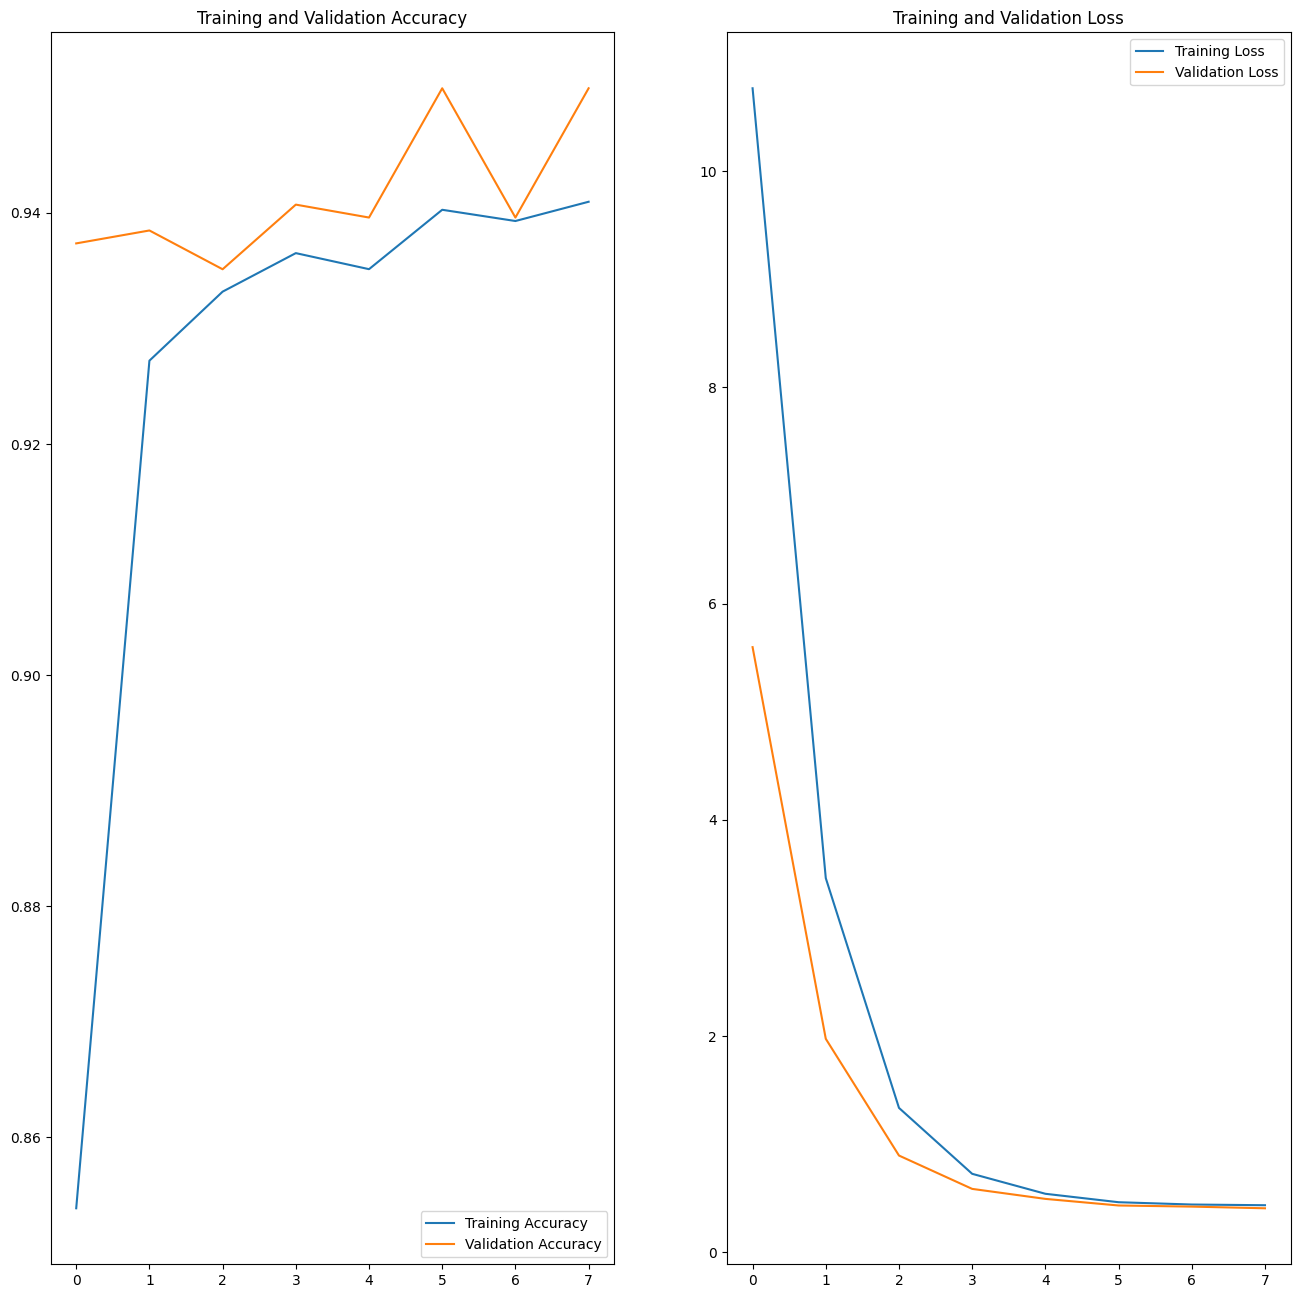

In [124]:
acc = result.history['accuracy']
val_acc = result.history['val_accuracy']

loss = result.history['loss']
val_loss = result.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [125]:
test_steps_per_epoch = np.math.ceil(test_set.samples / test_set.batch_size)

predictions = model.predict(test_set, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_set.classes
class_labels = list(test_set.class_indices.keys())   

from sklearn.metrics import  classification_report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report) 

29/29 [==============================] - 28s 810ms/step
              precision    recall  f1-score   support

           0       0.84      0.95      0.89        60
           1       0.97      0.98      0.97        57
           2       0.93      0.98      0.96        44
           3       0.88      0.95      0.91        55
           4       0.91      0.93      0.92        54
           5       1.00      0.89      0.94        44
           6       0.87      0.88      0.87        59
           7       0.98      0.96      0.97        54
           8       0.96      0.86      0.91        56
           9       0.96      0.89      0.93        56
         add       1.00      0.98      0.99        61
         dec       1.00      1.00      1.00        63
         div       1.00      1.00      1.00        63
          eq       1.00      1.00      1.00        64
         mul       0.98      0.98      0.98        59
         sub       1.00      1.00      1.00        66

    accuracy            

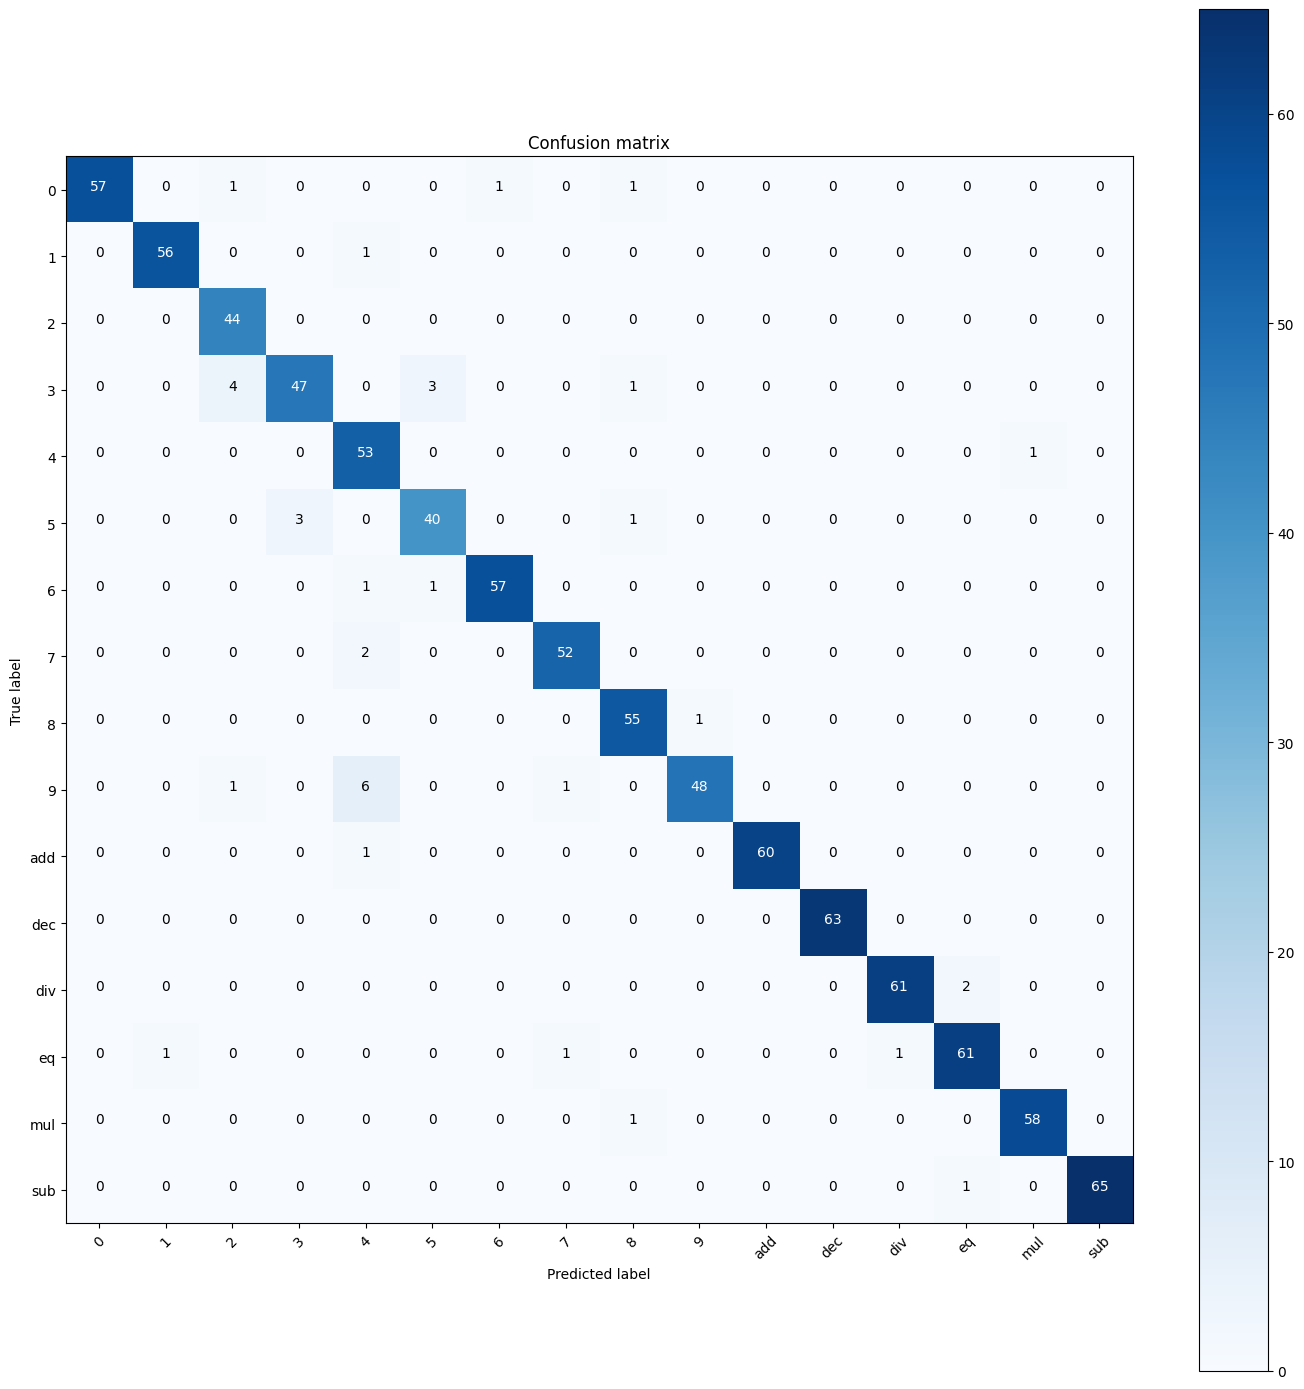

In [18]:
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# compute the confusion matrix
confusion_mtx = confusion_matrix(true_classes, predicted_classes) 
# plot the confusion matrix

plt.figure(figsize=(14, 14))
plot_confusion_matrix(confusion_mtx, classes = class_labels) 

In [129]:
from keras.utils import load_img, img_to_array
from keras.applications.mobilenet_v2 import preprocess_input

#load the image
my_image = load_img('./proba.png', color_mode='rgb', target_size=image_shape)

#preprocess the image
my_image = img_to_array(my_image)
my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
my_image = preprocess_input(my_image)
print(type(my_image))
#make the prediction
predict = model.predict(my_image)

<class 'numpy.ndarray'>


2023-05-10 03:44:04.932777: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at conv_ops_fused_impl.h:719 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 1 vs 3


InvalidArgumentError: Graph execution error:

Detected at node 'model/Conv1_relu/Relu6' defined at (most recent call last):
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_21717/4144704013.py", line 13, in <module>
      predict = model.predict(my_image)
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/site-packages/keras/engine/training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/site-packages/keras/engine/training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/site-packages/keras/engine/training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/site-packages/keras/engine/training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/site-packages/keras/engine/training.py", line 1983, in predict_step
      return self(x, training=False)
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/site-packages/keras/engine/training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/site-packages/keras/engine/functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/site-packages/keras/engine/functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/site-packages/keras/layers/activation/relu.py", line 105, in call
      return backend.relu(
    File "/home/bob9952/miniconda3/envs/ri_project/lib/python3.9/site-packages/keras/backend.py", line 5363, in relu
      x = tf.nn.relu6(x)
Node: 'model/Conv1_relu/Relu6'
input depth must be evenly divisible by filter depth: 1 vs 3
	 [[{{node model/Conv1_relu/Relu6}}]] [Op:__inference_predict_function_1870338]

In [127]:
predict

array([[2.6536749e-03, 2.6663423e-02, 9.9012326e-04, 6.6891462e-02,
        6.9343798e-02, 1.0278260e-01, 2.0654693e-02, 2.4128873e-02,
        5.7941914e-01, 6.3325778e-02, 4.8918265e-04, 1.7852394e-03,
        6.6939876e-03, 3.3455209e-03, 2.8201917e-02, 2.6306368e-03]],
      dtype=float32)

In [128]:
class_labels[ np.argmax([np.round(x) for x in predict]) ]

'8'

Tip koji se predvidja:  <class 'numpy.ndarray'>
1/1 [==============================] - 0s 166ms/step
[[3.00037991e-02 1.80161814e-03 9.51659094e-05 9.95133596e-05
  3.60288745e-04 5.77146048e-03 3.99861834e-04 8.54171291e-02
  6.50595874e-04 1.45089235e-02 6.28978232e-05 4.01045755e-02
  1.43010897e-04 3.84427869e-04 6.62864302e-04 8.19533825e-01]]
sub


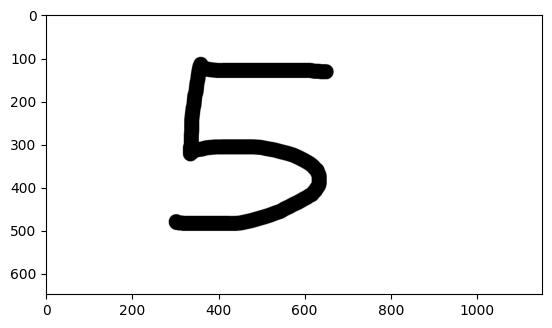

In [159]:

# img_to_pred = roi
# img_to_pred = load_img('../projekat/characters/5.png')


# prediction(img_to_pred)

plt.imshow(img_to_pred)

In [197]:
def prediction(my_image, i):
    my_image = np.asarray(my_image)
    # my_image = img_to_array(my_image)   pretvara PIL u np.array
    my_image = cv2.resize(my_image, dsize=(image_shape[0], image_shape[1]))
    
    
    
    

    plt.subplot(2,2, i)
    plt.imshow(my_image)
    
    
    
    
    
    my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
    
    my_image = preprocess_input(my_image)
    
#     print("Tip koji se predvidja: ",type(my_image))
    
    prediction = model.predict(my_image)
    
    
#     img = cv2.resize(img,(40, 40))
#     norm_image = cv2.normalize(img, None, alpha = 0, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
#     norm_image = norm_image.reshape((norm_image.shape[0], norm_image.shape[1], 1))
#     case = np.asarray([norm_image])
#     pred = model.predict_classes([case])
    # print(class_labels[ np.argmax([np.round(x) for x in prediction]) ])
    
    
#     print(prediction)
    print(class_labels[ np.argmax(prediction[0])])
    
    return class_labels[ np.argmax(prediction[0]) ]

1/1 [==============================] - 0s 20ms/step
0
1/1 [==============================] - 0s 19ms/step
4
1/1 [==============================] - 0s 19ms/step
dec
1/1 [==============================] - 0s 19ms/step
8


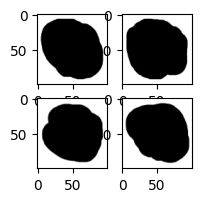

In [202]:
image = cv2.imread('../projekat/characters/proba.png')


###
plt.figure(figsize=(2, 2))
###

bounding = 10

# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
slika = image
blurred = cv2.GaussianBlur(slika, (5, 5), 0)


edged = cv2.Canny(blurred, 30, 150)
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]
chars=[]

i = 0
for c in cnts:
    # compute the bounding box of the contour
    (x, y, w, h) = cv2.boundingRect(c)
    # filter out bounding boxes, ensuring they are neither too small
    # nor too large
    if w*h>1200:
        # extract the character and threshold it to make the character
        # appear as *white* (foreground) on a *black* background, then
        # grab the width and height of the thresholded image
        roi = slika[y - bounding:y + h + bounding, x - bounding:x + w +bounding]
        
        # plt.imshow(roi)
        # print(x, y, w, h)
        i += 1
        chars.append(prediction(roi, i))
        cv2.rectangle(image, (x-bounding, y-bounding), (x + w + bounding, y + h + bounding), (0, 255, 0), 10)

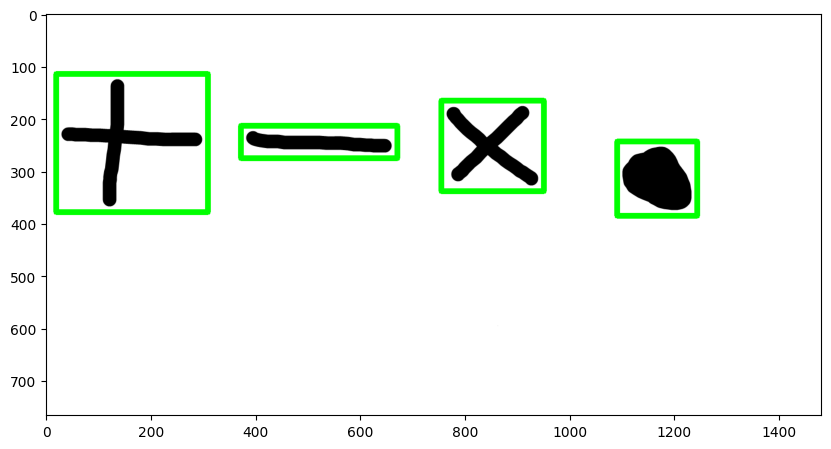

In [191]:
plt.figure(figsize=(10,10))
plt.imshow(image)

In [43]:
chars

['0', 'sub', '0', '0']